In [1]:
import torch
import torch.utils.data as Data
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import sb
from sb import model

/mnt/data/zoujm/jmzou/anaconda3/envs/priscient/sb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 将图像调整为 32x32
    transforms.ToTensor(),        # 将图像转换为张量
])
train_data  = MNIST(
    root = "./data", # 数据的路径
    train = True, # 只使用训练数据集
    transform  = transform,
    download= False  #因为数据已经下载过，所以这里不再下载
)
def extract_transformed_data(dataset, labels):
    data = []
    for i in range(len(dataset)):
        if dataset.targets[i]==labels:
            img, label = dataset[i]  # 这里会应用 transform
            data.append(img.numpy())  # 转换为 NumPy 数组
    return torch.tensor(np.stack(data,axis=0))
scaler = MinMaxScaler(feature_range=(-10, 10))
digit_1_data = extract_transformed_data(train_data,1)
digit_7_data = extract_transformed_data(train_data,7)
digit_9_data = extract_transformed_data(train_data,9)
digit_1_data = digit_1_data.reshape(digit_1_data.shape[0],-1)
digit_7_data = digit_7_data.reshape(digit_7_data.shape[0],-1)
digit_9_data = digit_9_data.reshape(digit_9_data.shape[0],-1)
scaler.fit(torch.cat([digit_1_data,digit_7_data,digit_9_data],dim=0))
digit_1_scaled=torch.from_numpy(scaler.transform(digit_1_data))
digit_7_scaled=torch.from_numpy(scaler.transform(digit_7_data))
digit_9_scaled=torch.from_numpy(scaler.transform(digit_9_data))

In [10]:
steps = 30*2
eps = 10
eps_test = 10
sb_object=model.sb_muti_model([digit_1_scaled,digit_7_scaled,digit_9_scaled],[0,1,2],N_pretraining=200,N_finetuning=50,
                              base_lr=1e-3,finetuning_lr=1e-3,
                              steps=steps,eps=eps,patience=20000,B=128,lambda_=1e-3,clamp=False,save=True)

processed: 101:  50%|█████     | 101/200 [20:15<19:50, 12.03s/it, loss=958.3150175616188, loss_fore=1012.0919023128185, loss_back=904.538132810419] 

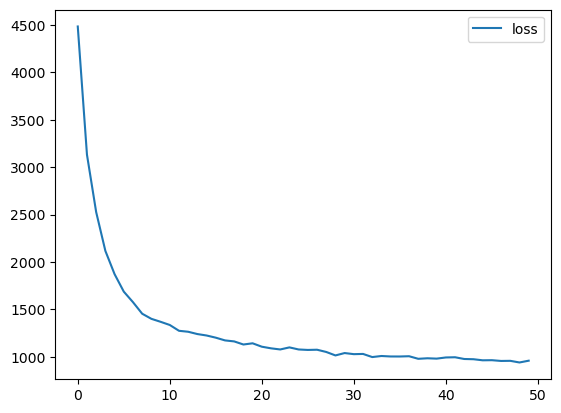

processed: 200: 100%|██████████| 200/200 [40:06<00:00, 12.03s/it, loss=878.1180782659404, loss_fore=943.9475691822079, loss_back=812.2885873496724] 


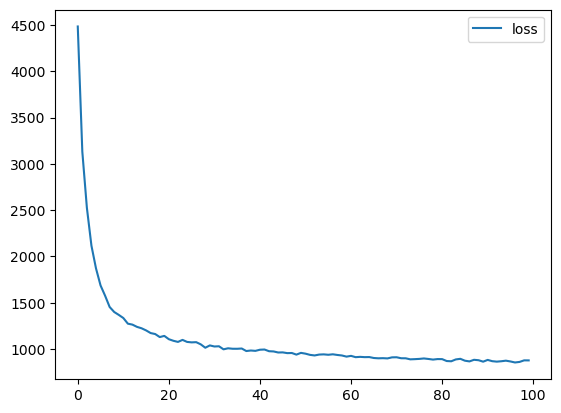

In [11]:
sb_object.run_base()

In [13]:
fore_base=sb_object.eval_fore(digit_1_scaled.double()[:128,:],sb_object.v_fore,eps_test=eps_test)
back_base=sb_object.eval_back(digit_9_scaled.double()[:128,:],sb_object.v_back,eps_test=eps_test)

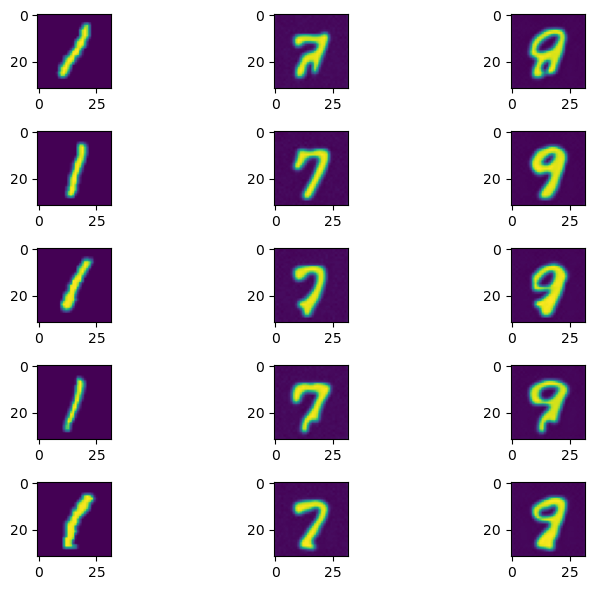

In [14]:
y=np.random.randint(0,128,5)
n=5
fig, axes = plt.subplots(n, 3, figsize=(8, 6))  # 1行x列的子图
# 在每个子图中显示图像
for j in range(n):
        axes[j,0].imshow(fore_base[0].reshape(fore_base[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,1].imshow(fore_base[30].reshape(fore_base[30].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,2].imshow(fore_base[-1].reshape(fore_base[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
# 调整布局
plt.tight_layout()
plt.show()

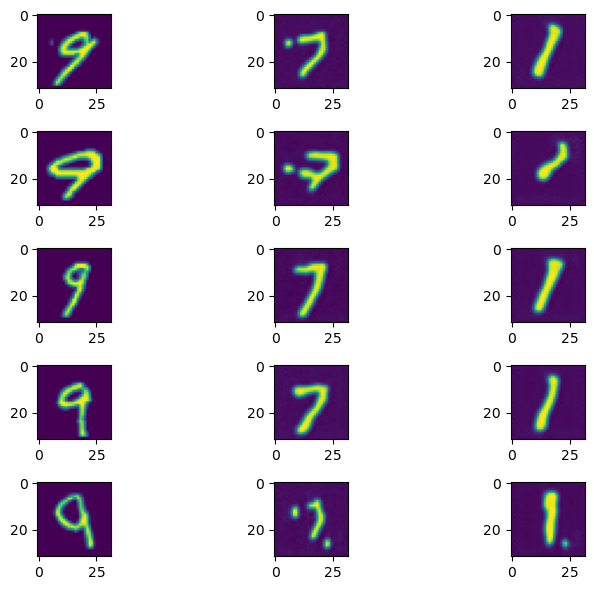

In [15]:
y=np.random.randint(0,128,5)
n=5
fig, axes = plt.subplots(n, 3, figsize=(8, 6))  # 1行x列的子图
# 在每个子图中显示图像
for j in range(n):
        axes[j,0].imshow(back_base[0].reshape(back_base[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,1].imshow(back_base[30].reshape(back_base[30].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,2].imshow(back_base[-1].reshape(back_base[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
# 调整布局
plt.tight_layout()
plt.show()

processed: 50: 100%|██████████| 50/50 [2:46:15<00:00, 199.50s/it, loss=938.6506521018256]  


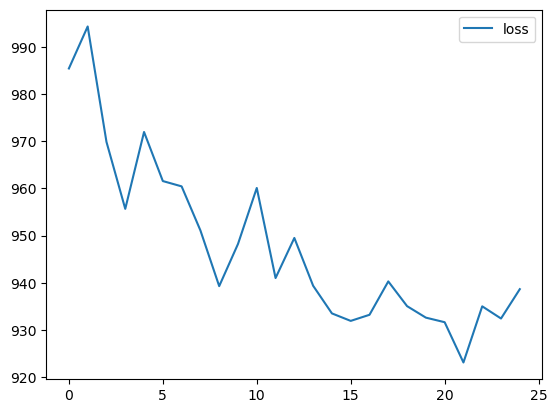

In [16]:
sb_object.finetuning()

In [17]:
fore_ft=sb_object.eval_fore(digit_1_scaled.double()[:128,:],sb_object.v_fore_copy,eps_test=eps_test)
back_ft=sb_object.eval_back(digit_9_scaled.double()[:128,:],sb_object.v_back_copy,eps_test=eps_test)

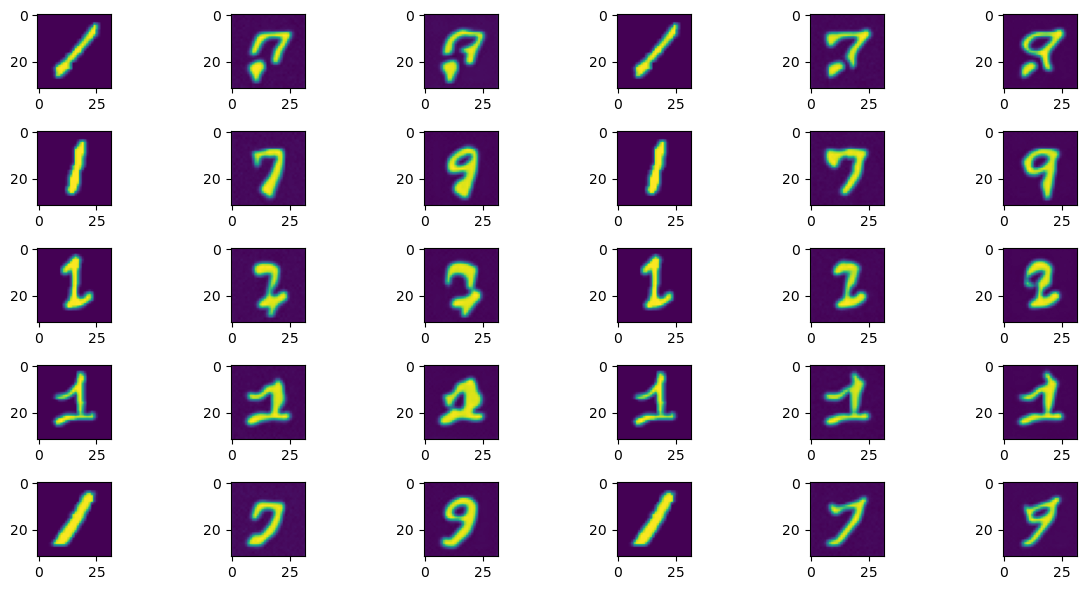

In [19]:
y=np.random.randint(0,128,5)
n=5
fig, axes = plt.subplots(n, 6, figsize=(12, 6))  # 1行x列的子图
# 在每个子图中显示图像
for j in range(n):
        axes[j,0].imshow(fore_base[0].reshape(fore_base[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,1].imshow(fore_base[30].reshape(fore_base[30].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,2].imshow(fore_base[-1].reshape(fore_base[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,3].imshow(fore_ft[0].reshape(fore_ft[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,4].imshow(fore_ft[30].reshape(fore_ft[30].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,5].imshow(fore_ft[-1].reshape(fore_ft[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
# 调整布局
plt.tight_layout()
plt.show()

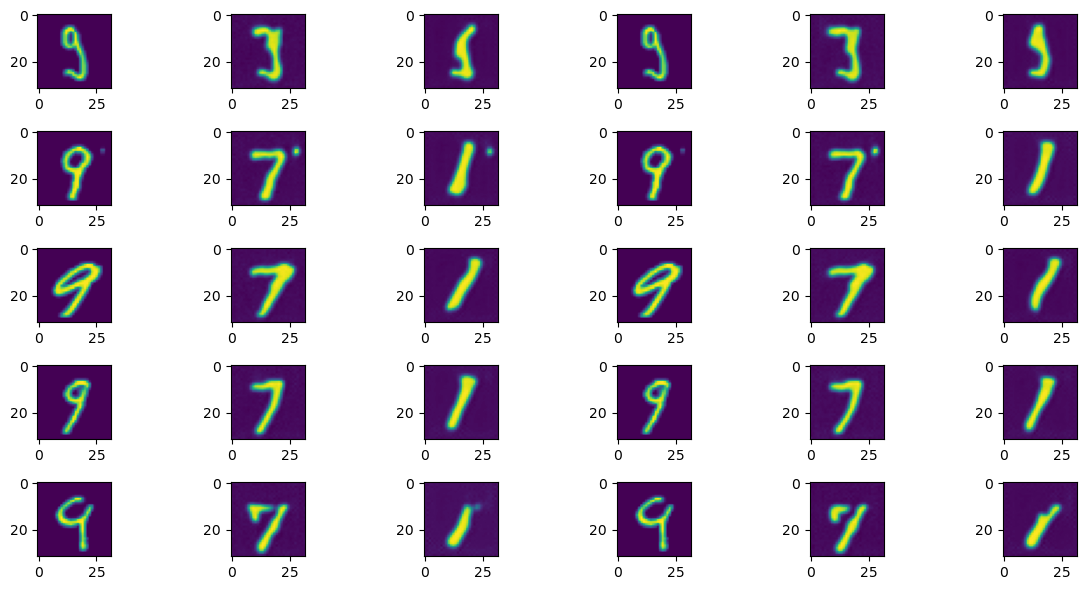

In [21]:
y=np.random.randint(0,128,5)
n=5
fig, axes = plt.subplots(n, 6, figsize=(12, 6))  # 1行x列的子图
# 在每个子图中显示图像
for j in range(n):
        axes[j,0].imshow(back_base[0].reshape(back_base[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,1].imshow(back_base[30].reshape(back_base[20].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,2].imshow(back_base[-1].reshape(back_base[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,3].imshow(back_ft[0].reshape(back_ft[0].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,4].imshow(back_ft[30].reshape(back_ft[20].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
        axes[j,5].imshow(back_ft[-1].reshape(back_ft[-1].shape[0],32,32)[y[j],:,:], cmap='viridis')  # 使用'viridis'颜色映射
# 调整布局
plt.tight_layout()
plt.show()